In [38]:
from time import time
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from datetime import datetime, timedelta
import ensemble_kalman_filter as enkf
from tqdm import tqdm
from bayes_opt import BayesianOptimization
from rebayes_mini.methods import robust_filter as rkf
from rebayes_mini import callbacks

In [39]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
plt.style.use("default")
plt.rcParams["font.size"] = 18

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
def rk4_step(y, i, dt, f):
    h = dt
    t = dt * i
    k1 = h * f(y, t)
    k2 = h * f(y + k1 / 2, dt * i + h / 2)
    k3 = h * f(y + k2 / 2, t + h / 2)
    k4 = h * f(y + k3, t + h)

    y_next = y + 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return y_next

    

@partial(jax.jit, static_argnames=("f",))
def rk4(ys, dt, N, f):
    """
    Based on
    https://colab.research.google.com
    github/google/jax/blob/master/cloud_tpu_colabs/Lorentz_ODE_Solver
    """
    @jax.jit
    def step(i, ys):
        ysi = rk4_step(ys[i - 1], i, dt, f)
        return ys.at[i].set(ysi)
    return jax.lax.fori_loop(1, N, step, ys)

(5000, 3)


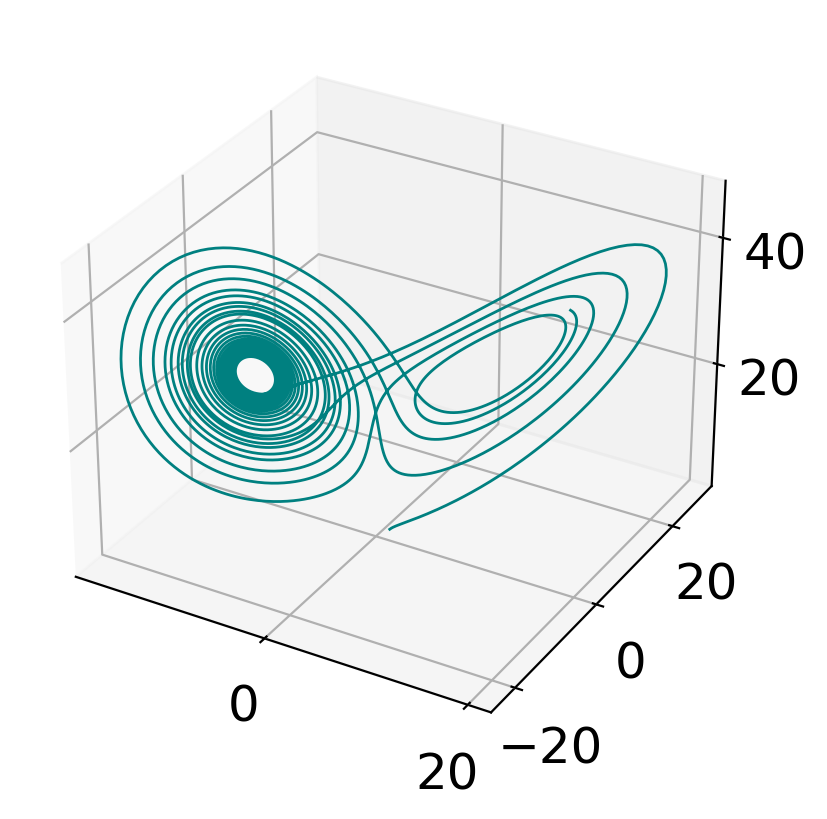

In [41]:
sigma = 10.
beta = 8./3
rho = 28.


def f(state, t):
    x, y, z = state
    xdot = sigma * (y - x)
    ydot = x * (rho - z) - y
    zdot = x * y - beta * z
    return jnp.array([xdot, ydot, zdot])

y0 = jnp.ones(3)
N = 5000
ys = jnp.zeros((N,) + y0.shape)
ys = ys.at[0].set(y0)
res = rk4(ys, 0.004, N, f)
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*res.T, lw=1.0, c="teal")
print(res.shape)

$$
    \dot{\bf x}_k = \Big({\bf x}_{k+1} - {\bf x}_{k-2}\Big) {\bf x}_{j-1} - {\bf x}(j) + {F}_k
$$


In [42]:
D = 72
F = 8.0
# ixs = jnp.arange(D)
save_dir ='../dataset/lorenz96_' + str(D) + '_mc/'

key = jax.random.PRNGKey(31415)
key_init, key_sim, key_eval, key_obs = jax.random.split(key, 4)


key_state, key_measurement = jax.random.split(key_sim)

@partial(jax.vmap, in_axes=(None, 0, None))
def fcoord(x, k, D):
    xdot = (x[(k + 1) % D] - x[k - 2]) * x[k - 1] - x[k] + F
    return xdot

def f(x, t, D, *args):
    keyt = jax.random.fold_in(key_state, t)
    err = jax.random.normal(keyt, shape=(D,))
    ixs = jnp.arange(D)
    xdot = fcoord(x, ixs, D) + F + err
    return xdot

def make_obs_matrix(dim, rank, random_seed):
    """
    Generates a random low rank matrix

    Args:
        dim (int): dimension of matrix
        rank (int): rank of matrix
        random_seed (int, optional): random seed of matrix. Defaults to None.

    Returns:
        numpy.ndarray: matrix of rank and dim
    """
    # if random_seed is not None:
    #     np.random.seed(random_seed)
    assert dim >= rank, "rank cannot be greater than dim."
    u = np.random.randn(rank, dim, 1)
    return (u @ u.transpose((0, 2, 1))).sum(axis=0) / rank

H = make_obs_matrix(D, D, key_obs)

def hcoord(x, t):
    return H @ x

def h(x, t, D, *args):
    keyt = jax.random.fold_in(key_measurement, t)
    err = jax.random.normal(keyt, shape=(D,))
    ydot = hcoord(x, t) + err
    return ydot

@partial(jax.jit, static_argnames=("h",))
def h_step(ys, dt, N, h):
    @jax.jit
    def step(i, ys):
        ysi = h(ys[i - 1], dt * i)
        return ys.at[i].set(ysi)
    return jax.lax.fori_loop(1, N, step, ys)

In [43]:
n_mc = 1
N = 512
dt = 0.01
p_err = 0.01
corrupted = True
xs_mc = []
ys_mc = []
ys_corrupted_mc = []
key_obs, key_mc = jax.random.split(key_obs)
for i in range(n_mc):
    key_mc, subkey = jax.random.split(key_mc)  # 生成新的子随机数生成器
    x0 = jax.random.normal(key_mc, (D,)) + F
    xs1 = jnp.zeros((N,) + x0.shape)
    xs1 = xs1.at[0].set(x0)
    fpart = partial(f, D=D)
    xs1 = rk4(xs1, dt, N, fpart)
    hpart = partial(h, D=D)
    ys1 = xs1 + jax.random.normal(key_measurement, xs1.shape)
    ys1_corrupted = ys1.copy()
    if corrupted:
        errs_map = jax.random.bernoulli(key_init, p=p_err, shape=ys1_corrupted.shape)
        ys1_corrupted = ys1_corrupted * (~errs_map) + 100.0 * errs_map
        err_where = np.where(errs_map)
    xs_mc.append(xs1)
    ys_mc.append(ys1)
    ys_corrupted_mc.append(ys1_corrupted)
statev = jnp.array(xs_mc)
yv = jnp.array(ys_mc)
yv_corrupted = jnp.array(ys_corrupted_mc)
print(statev.shape)
print(yv.shape)
print(yv_corrupted.shape)

(1, 512, 72)
(1, 512, 72)
(1, 512, 72)


In [44]:
ys = yv.reshape(-1, D)
ys_corrupted = yv_corrupted.reshape(-1, D)
xs = statev.reshape(-1, D)
print(xs.shape,ys.shape)

(512, 72) (512, 72)


In [45]:
# 生成时间序列
start_time = datetime(2024, 6, 22, 13, 0, 0)
time_interval = timedelta(seconds=1)
time_series = [start_time + i * time_interval for i in range(xs.shape[0])]

# 创建 DataFrame
column_names = [f'x_{i}' for i in range(1, xs.shape[1] + 1)]
df = pd.DataFrame(xs, columns=column_names)
df.insert(0, 'date', time_series)

print(df.head())

                 date       x_1       x_2       x_3       x_4       x_5  \
0 2024-06-22 13:00:00  7.930324  8.413463  7.601623  9.190229  8.475810   
1 2024-06-22 13:00:01  8.009968  8.579210  7.780342  9.260442  8.497171   
2 2024-06-22 13:00:02  8.098575  8.749910  7.957643  9.317677  8.499048   
3 2024-06-22 13:00:03  8.196843  8.926337  8.131474  9.359551  8.482053   
4 2024-06-22 13:00:04  8.305633  9.109092  8.299394  9.383612  8.447261   

        x_6       x_7       x_8       x_9  ...      x_63      x_64      x_65  \
0  7.100482  7.611787  8.599230  5.906620  ...  8.527282  8.186784  8.320616   
1  7.073041  7.707716  8.593732  5.914496  ...  8.550789  8.175250  8.459203   
2  7.048300  7.801516  8.589634  5.918190  ...  8.562858  8.166275  8.595986   
3  7.027606  7.894645  8.586485  5.919594  ...  8.563631  8.161030  8.731611   
4  7.012574  7.988447  8.583830  5.920499  ...  8.553515  8.160720  8.866547   

       x_66      x_67      x_68      x_69      x_70      x_71      x

In [46]:
# # 保存为 CSV 文件
# csv_path = '../dataset/lorenz96_20_shuffle/lorenz96_72mc.csv'
# df.to_csv(csv_path, index=False)
# # 创建 DataFrame
# column_names = [f'y_{i}' for i in range(1, ys.shape[1] + 1)]
# dfy = pd.DataFrame(ys, columns=column_names)
# dfy.insert(0, 'date', time_series)

# print(dfy.head())
# csv_path = '../dataset/lorenz96_20_shuffle/lorenz96_72mc_obs.csv'
# df.to_csv(csv_path, index=False)

# column_names = [f'y_{i}' for i in range(1, ys_corrupted.shape[1] + 1)]
# dfy = pd.DataFrame(ys_corrupted, columns=column_names)
# dfy.insert(0, 'date', time_series)

# print(dfy.head())
# csv_path = '../dataset/lorenz96_20_shuffle/lorenz96_72mc_obs_corrupted.csv'
# df.to_csv(csv_path, index=False)

In [47]:
range_time = np.arange(N) * dt
np.set_printoptions(precision=4)

def callback_fn(particles, particles_pred, y, i):
    return jnp.sqrt(jnp.power(particles.mean(axis=0) - xs[i], 2).mean()), particles.mean(axis=0)
def latent_fn(x, key, i):
    """
    State function
    """
    err = jax.random.normal(key, (D,))
    @jax.jit
    def f(x, t):
        ixs = jnp.arange(D)
        return fcoord(x, ixs, D) + F + err
    
    return rk4_step(x, i, dt, f)


def obs_fn(x, key, i):
    """
    Measurement function
    """
    err = jax.random.normal(key, (D,))
    return hcoord(x, i) + err

def calculate_mse(errs):
    return jnp.mean(jnp.square(errs))
def calculate_mae(errs):
    return jnp.mean(jnp.abs(errs))

def calculate_rmse(errs):
    return jnp.sqrt(jnp.mean(jnp.square(errs)))

def calculate_test_error(errs):
    mse = calculate_mse(errs)
    mae = calculate_mae(errs)
    rmse = calculate_rmse(errs) 
    print(f'mse:{mse}, mae:{mae}, rmse:{rmse}')
    return mse, mae, rmse


In [48]:
# y_index = int(0.8 * ys.shape[0])
# print(ys.shape)
# # 截取最后 20% 的数据
# ys = ys[y_index:]
# ys_corrupted = ys_corrupted[y_index:]
# print(ys.shape)
time_methods = {}
hist_methods = {}
errs_methods = {}

In [60]:
def filter_enkf(x0, n_particles, measurements, state, key_eval):
    agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)
    key_init_particles, key_scan = jax.random.split(key_eval, 2)
    X0 = agent.init_bel(key_init_particles, D)
    particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, measurements, callback_fn=callback_fn)
    return errs, particles_hist_mean

def filter_enkfi(x0, inflation_factor, n_particles, measurements, state, key_eval):
    agent = enkf.EnsembleKalmanFilterInflation(latent_fn, obs_fn, n_particles, inflation_factor=inflation_factor)
    key_init_particles, key_scan = jax.random.split(key_eval, 2)
    X0 = agent.init_bel(key_init_particles, D)
    particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, measurements, callback_fn=callback_fn)
    return errs, particles_hist_mean

def filter_ekf(x0, measurements, state, key_eval):
    nsteps = len(measurements)
    agent_imq = rkf.ExtendedKalmanFilterIMQ(
        fcoord, hcoord,
        dynamics_covariance=jnp.eye(D),
        observation_covariance=jnp.eye(D),
        soft_threshold=1e8,
    )
    init_bel = agent_imq.init_bel(x0, cov=1.0)
    filterfn = partial(agent_imq.scan, callback_fn=callbacks.get_updated_mean)
    _, hist = filterfn(init_bel, measurements, jnp.ones(N))

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist

In [50]:
method = 'EnKF_1000'
n_particles = 1000
hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_mc): 
    tinit = time()
    key_eval, key_scan = jax.random.split(key_eval)
    # print(xs[0])
    errs, _ = filter_enkf(state[0], n_particles, y, state, key_eval)
    tend = time()
    
    hist_bel.append(errs)
    times.append(tend - tinit)

errs = np.stack(hist_bel)
time_methods[method] = times
print(method)
errs_test = errs[int(errs.shape[0] * 0.8):]
_, _, errs_methods[method] = calculate_test_error(errs_test)


  0%|          | 0/1 [00:00<?, ?it/s]

(512, 72) (72,)


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

EnKF_1000
mse:nan, mae:nan, rmse:nan


In [53]:
method = 'EnKFI_1000'
n_particles = 10000
inflation_factor = 3.0
hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_mc): 
    tinit = time()
    key_eval, key_scan = jax.random.split(key_eval)
    errs, _ = filter_enkfi(state[0], inflation_factor, n_particles, y, state, key_eval)
    tend = time()
    
    hist_bel.append(errs)
    times.append(tend - tinit)

errs = np.stack(hist_bel)
time_methods[method] = times
print(method)
errs_test = errs[int(errs.shape[0] * 0.8):]
_, _, errs_methods[method] = calculate_test_error(errs_test)

100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

EnKFI_1000
mse:nan, mae:nan, rmse:nan


In [54]:
print(errs.shape)
print(errs_test.shape)

(1, 512)
(1, 512)


In [61]:
method = 'EKF'
hist_bel = []
times = []
errs = 0
for y, state in tqdm(zip(yv, statev), total=n_mc): 
    tinit = time()
    key_eval, key_scan = jax.random.split(key_eval)
    errs, _ = filter_ekf(state[0], y, state, key_eval)
    tend = time()
    
    hist_bel.append(errs)
    times.append(tend - tinit)

errs = np.stack(hist_bel)
time_methods[method] = times
print(method)
errs_test = errs[int(errs.shape[0] * 0.8):]
_, _, errs_methods[method] = calculate_test_error(errs_test)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: vmap in_axes specification must be a tree prefix of the corresponding value, got specification (None, 0, None) for value tree PyTreeDef((*,)).

In [18]:
method = 'EnKFI_20_3'
n_particles = 20
inflation_factor = 3.0
agent = enkf.EnsembleKalmanFilterInflation(latent_fn, obs_fn, n_particles, inflation_factor=inflation_factor)
# agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)
key_init_particles, key_scan = jax.random.split(key_eval, 2)
X0 = agent.init_bel(key_init_particles, D)
tinit = time()
particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, ys, callback_fn=callback_fn)
tend = time()
time_cost = tend - tinit
calculate_test_error(errs[errs_index:])
print('time cost (ms):', time_cost)
tinit = time()
particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, ys_corrupted, callback_fn=callback_fn)
tend = time()
time_cost = tend - tinit
print('corrupted')
calculate_test_error(errs[errs_index:])
print('time cost (ms):', time_cost)

NameError: name 'errs_index' is not defined

In [ ]:
method = 'EnKFI_1000_3'
n_particles = 100000
inflation_factor = 3.0
agent = enkf.EnsembleKalmanFilterInflation(latent_fn, obs_fn, n_particles, inflation_factor=inflation_factor)
# agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)
key_init_particles, key_scan = jax.random.split(key_eval, 2)
X0 = agent.init_bel(key_init_particles, D)
tinit = time()
particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, ys, callback_fn=callback_fn)
tend = time()
time_cost = tend - tinit
calculate_test_error(errs[errs_index:])
print('time cost (ms):', time_cost)
tinit = time()
particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, ys_corrupted, callback_fn=callback_fn)
tend = time()
time_cost = tend - tinit
print('corrupted')
calculate_test_error(errs[errs_index:])
print('time cost (ms):', time_cost)

2024-06-22 19:46:05.239069: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 37.25GiB (rounded to 40000000000)requested by op 
2024-06-22 19:46:05.239325: W external/tsl/tsl/framework/bfc_allocator.cc:497] *___________________________________________________________________________________________________
2024-06-22 19:46:05.239394: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2463] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 40000000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         0B
              constant allocation:         0B
        maybe_live_out allocation:   37.25GiB
     preallocated temp allocation:         0B
                 total allocation:   37.25GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 37.25GiB
		Operator: op_name="jit(iota)/jit(main)/iota[dtype=

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 40000000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         0B
              constant allocation:         0B
        maybe_live_out allocation:   37.25GiB
     preallocated temp allocation:         0B
                 total allocation:   37.25GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 37.25GiB
		Operator: op_name="jit(iota)/jit(main)/iota[dtype=int32 shape=(100000, 100000) dimension=0]" source_file="/home/liushiqi/liusq/DeepLearning/AutoTimes/data_generator/ensemble_kalman_filter.py" source_line=31
		XLA Label: iota
		Shape: s32[100000,100000]
		==========================



In [ ]:
print(errs[10:])

[nan nan nan ... nan nan nan]


In [ ]:
# n_particles = 20
# inflation_factor = 3.0
# agent = enkf.EnsembleKalmanFilterInflation(latent_fn, obs_fn, n_particles, inflation_factor=inflation_factor)
# # agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)
# key_init_particles, key_scan = jax.random.split(key_eval, 2)
# X0 = agent.init_bel(key_init_particles, D)
# tinit = time()
# particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, ys, callback_fn=callback_fn)
# tend = time()
# time_cost = tend - tinit
# calculate_test_error(errs)

In [ ]:
# n_particles = 1000
# inflation_factor = 3.0
# agent = enkf.EnsembleKalmanFilterInflation(latent_fn, obs_fn, n_particles, inflation_factor=inflation_factor)
# # agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)
# key_init_particles, key_scan = jax.random.split(key_eval, 2)
# X0 = agent.init_bel(key_init_particles, D)
# tinit = time()
# particles_end, (errs, particles_hist_mean) = agent.scan(X0, key_scan, ys, callback_fn=callback_fn)
# tend = time()
# time_cost = tend - tinit
# calculate_test_error(errs)